First we import the library, forcing reload from local version (not pip install). 

In [1]:
import os
import sys
import importlib
import matplotlib.pyplot as plt


# Get the absolute path to the directory containing the local module
stlrom_path = os.path.abspath('../build')
print(stlrom_path)

# Insert the local module path at the beginning of sys.path
sys.path.insert(0, stlrom_path)

import stlrom

# Reload the module to ensure it is loaded from the new path
importlib.reload(stlrom)

import stlrom as sr
import numpy as np


/home/alex/Dropbox/workspace/decyphir/Det-ai/STLRom/build


# Signals


## Function


In [2]:
import matplotlib.pyplot as plt

# Plotting
def plot_signal(signal,label=None, fig=None):
    samples_list = signal.get_samples_list()

    if fig is None:
        fig = plt.figure(figsize=(15, 5)).gca()

    if label is None:
        label = f'Signal {len(fig.get_lines()) + 1}'

    fig.set_xlabel('Time')
    fig.set_ylabel('Value')
    fig.set_title('Signal Plot')
    fig.grid(True)
        

    def plot_sample(s, dt, color=None):
        if color is None:
            l, = fig.plot(s.time, s.value, marker='o')
            color = l.get_color()
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        else:
            l = fig.plot(s.time, s.value, marker='o', color=color)
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        return color,l
    
    
    s = samples_list[0]
    sn = samples_list[1]
    dt = sn.time-s.time
        
    col,l = plot_sample(s, dt)
    l[0].set_label(label)
    
    for i in range(1, len(samples_list)-1):
        s = samples_list[i]
        sn = samples_list[i+1]
        dt = sn.time-s.time
        plot_sample(s,dt,color=col)
    
    plot_sample(sn, signal.end_time-sn.time, col)
    #fig.plot(sn.time, sn.value, marker='o', color=col)
    fig.legend()
    fig.figure.canvas.draw()

    return fig

# Printing
def print_signal(signal):
    for s in signal.get_samples_list():
        s.print_sample()
    print('begin_time ', signal.begin_time)
    print('end_time    ',signal.end_time)



## Test signals

### Basic test signals

In [3]:
# One sample
sig0 = sr.Signal()
sig0.append_sample(0, -1)
sig0.append_sample(1., 1)

sig1 = sr.Signal()
sig1.append_sample(.3, 2)
sig1.append_sample(.6, 1.5)
sig1.append_sample(1.3, -3)



### Longer signals

<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

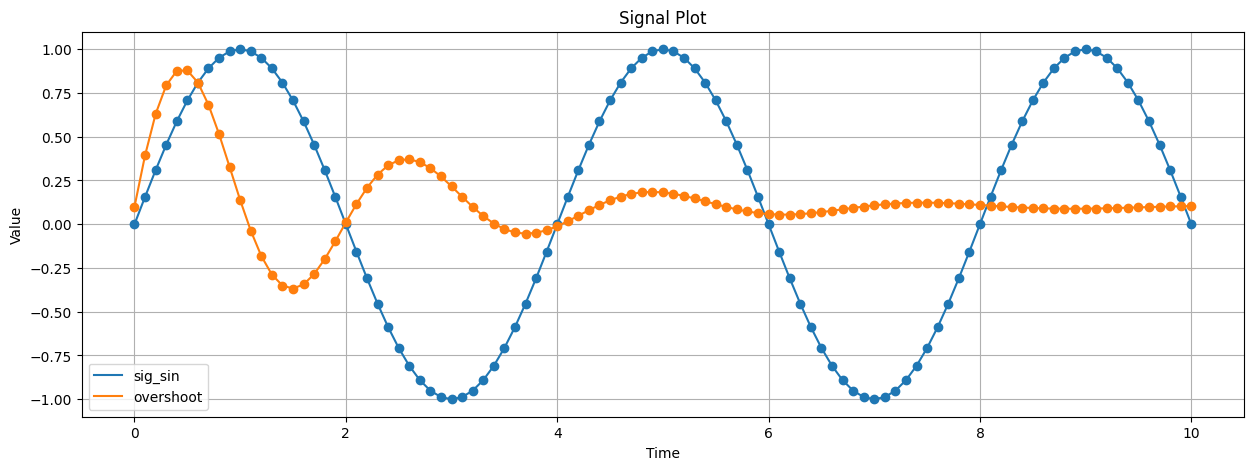

In [4]:
times = np.arange(0, 10.1, .1)
sin_val = np.sin(times*np.pi/2)
overshoot_val = np.sin(times*np.pi*np.exp(-times/50))*np.exp(-times/2)+.1
sig_sin = sr.Signal()
sig_overshoot = sr.Signal()

for i in range(0,len(times)):
    sig_sin.append_sample(times[i],sin_val[i])
    sig_overshoot.append_sample(times[i],overshoot_val[i])

fig= plot_signal(sig_sin, 'sig_sin')
plot_signal(sig_overshoot, 'overshoot', fig)

# Testing monitors


In [25]:
stl_parser = stlrom.STLDriver()
stl_parser.parse_string("""signal x, y       # declaring signals named 'x' and 'y'
param p=0.2, tau=5  # declaring parameters named 'p' and 'q'
# Let's add some formulas
mu_x := x[t] > p 
phi_x := ev_[0, tau] ( mu_x )
mu_y := y[t] < p 
mu := mu_x and mu_y 
phi_y := y[t]>p => ev_[0, tau] (y[t]<p)
""")


True

In [26]:
# Helper, to add data to a monitor
def add_signals(mon,times, sig_x, sig_y):
    for i in range(0, len(times)):
        mon.add_sample([times[i],sig_x[i],sig_y[i]])
    return mon


Monitoring phi_x

In [36]:
phi_x = stl_parser.get_monitor("phi_x")
phi_x_ltr = stl_parser.get_monitor("phi_x")

phi_x = add_signals(phi_x, times, sin_val, overshoot_val)
phi_x_ltr = add_signals(phi_x_ltr, times, sin_val, overshoot_val)



In [ ]:
phi_x_ltr.set_semantics("LEFT_TIME")

print(phi_x.get_semantics())
print(phi_x_ltr.get_semantics())

SPACE
LEFT_TIME


In [43]:
phi_x.set_eval_time(0,5)
phi_x.eval_robustness()

0.8

In [44]:
print_signal(phi_x.get_signal())

begin_time  0.0
end_time     5.0
Time 0.00000 Value 0.80000 Derivative 0.00000


## Some plots

<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

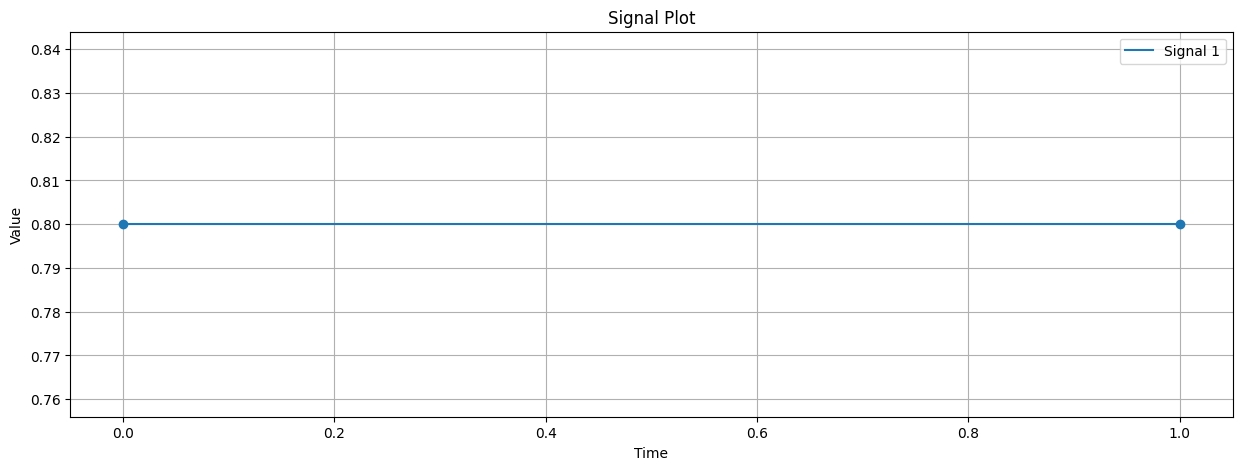

In [48]:
mu_x = stl_parser.get_monitor("phi_x")
mu_x = add_signals(mu_x, times, sin_val, overshoot_val)
mu_x.set_eval_time(0, 1) 
mu_x.eval_robustness()
z = mu_x.get_signal()
plot_signal(z)

IndexError: list index out of range

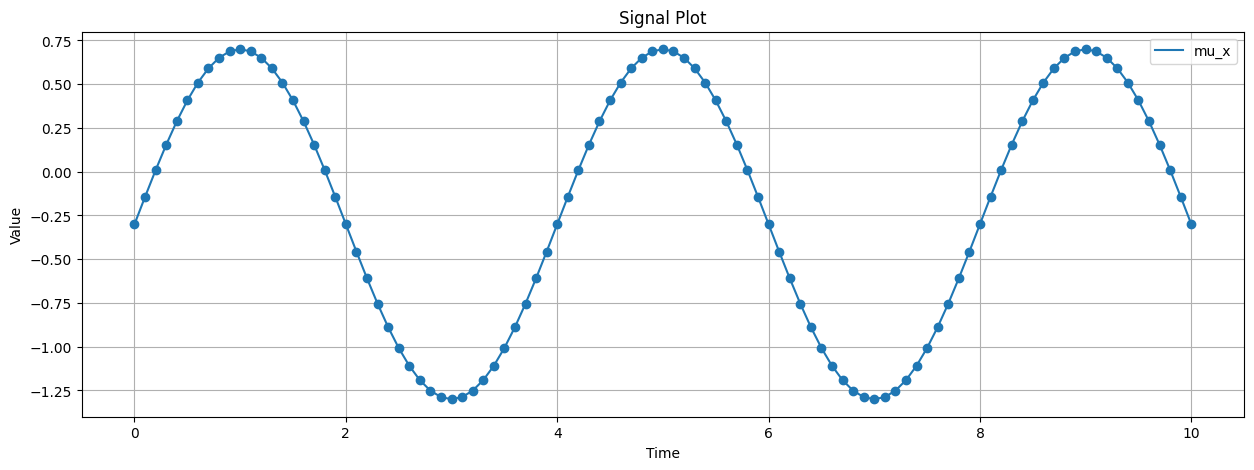

In [19]:
mu_x.set_eval_time(0, 10) 
ev_x.set_eval_time(0,6)
mu_x.set_param('p', .3)
ev_x.set_param('p', .3)

mu_x.eval_robustness()
rho_mu_x = mu_x.get_signal()
ev_x.eval_robustness()
rho_ev_x = ev_x.get_signal()


fig = plot_signal(rho_mu_x, 'mu_x')
plot_signal(rho_ev_x, 'rho(ev_x)', fig)


In [21]:

print_signal(rho_ev_x)

begin_time Time 0.00000 Value 0.70000 Derivative 0.00000
 0.0
end_time     6.0


In [22]:
ev_x

Signal Names: x, y
Parameters: p: 0.3, tau: 5
Formula: ev_[0,tau] (x[t] > p) 